In [ ]:
import re
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import numpy as np
import matplotlib.pyplot as plt

import os
import pickle #for reading images


import seaborn as sns
import scipy.ndimage
from skimage import measure, morphology

from keras.layers import Conv2D, MaxPool3D, Flatten, Dense
from keras.layers import Dropout, Input, BatchNormalization
from sklearn.metrics import confusion_matrix, accuracy_score
from plotly.offline import iplot, init_notebook_mode
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta

from keras.models import Model
import keras

from pathlib import Path

import matplotlib.patches as patch

from PIL import Image
from skimage.transform import resize    

import cv2

from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

!nvidia-smi

Sun Jun  6 20:59:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# directory where the volumetric data is located
volumetric_data_dir = '/content/drive/MyDrive/vol01'

# path to metadata csv file
metadata_csv_path = '/content/drive/MyDrive/metadata.csv'

# names=True loads the interprets the first row of csv file as column names
# 'i4' = 4 byte signed integer, 'U20' = unicode max 20 char string
metadata = np.genfromtxt(metadata_csv_path, delimiter=',', names=True, dtype='i4,i4,i4,i4,i4,i4,i4,i4,i4,i4,U20') 
#Load data from a text file, with missing values handled as specified.

print('Column names:')
print(metadata.dtype.names)

Column names:
('examId', 'seriesNo', 'aclDiagnosis', 'kneeLR', 'roiX', 'roiY', 'roiZ', 'roiHeight', 'roiWidth', 'roiDepth', 'volumeFilename')


In [ ]:
# Select all rows where examID == 502889
exams = metadata[metadata['examId'] == 404663]
print(exams)

[(404663, 8, 1, 1, 120, 117, 15, 101, 115, 2, '404663-8.pck')]


In [ ]:
for exam in exams:
    vol_data_file = exam['volumeFilename']
    print(vol_data_file)

    vol_data_path = os.path.join(volumetric_data_dir, vol_data_file)
    print(vol_data_path)

404663-8.pck
/content/drive/MyDrive/vol01/404663-8.pck


In [ ]:
# Load data from file

with open(vol_data_path, 'rb') as file_handler: # Must use 'rb' as the data is binary
    volumetric_data = pickle.load(file_handler)
    
print('\nShape of volume "%s":' % vol_data_path, volumetric_data.shape)


Shape of volume "/content/drive/MyDrive/vol01/404663-8.pck": (33, 320, 320)


In [ ]:
print(volumetric_data)

[[[  16   60   54 ...  985  986  896]
  [  68   17   33 ... 1009 1069 1018]
  [  56   81   89 ... 1079 1082 1091]
  ...
  [  89   92   55 ...   76   75   59]
  [  45  113   89 ...   41   79   28]
  [  73   23   75 ...   63   94   31]]

 [[ 125   65   54 ...  560  352  256]
  [  87   72   36 ...  488  265  237]
  [  68   41   45 ...  358  210  243]
  ...
  [  44   37   43 ...   24   29  120]
  [  73  140   96 ...   74   78   89]
  [ 109  131  100 ...   36   34   72]]

 [[  59   66   80 ...  334  310  374]
  [  21   64  117 ...  326  360  464]
  [  96    8   59 ...  366  452  521]
  ...
  [  94   44  137 ...   85   41   28]
  [  28   43   65 ...   24   93   53]
  [ 112   72   88 ...   88  142   63]]

 ...

 [[  63   49   39 ...  135   39   51]
  [  78  104   55 ...   79  109   87]
  [  57   95   72 ...   39  125   90]
  ...
  [  88   59   60 ...  127   95   59]
  [  70   44   34 ...  118   83   37]
  [  46   43   35 ...  113   41   60]]

 [[  70   22   44 ...   63   49   73]
  [  50   38

In [ ]:
# Get all roi slices from volume

z_start = exam['roiZ']
print(z_start)
depth = exam['roiDepth']
print(depth)
   
for z in range(z_start, z_start + depth):
    
    slice = volumetric_data[z, :, :]
        
print(slice)

15
2
[[ 30  39  95 ... 321 323 308]
 [ 97  49  66 ... 306 336 366]
 [ 72  60  72 ... 294 334 351]
 ...
 [ 44  80  92 ...  82 115  90]
 [ 89  74 100 ...  44  84  86]
 [ 87  65  46 ...  51  62  61]]


In [ ]:
# Get roi dimensions

x, y, w, h = [exam[attr] for attr in ['roiX', 'roiY', 'roiWidth', 'roiHeight']]
print(x,y,w,h) 

120 117 115 101


In [ ]:
# Extract ROI
roi = slice[y:y+h, x:x+w]
print(roi)

[[445 497 497 ... 673 619 446]
 [521 479 575 ... 646 609 491]
 [504 465 572 ... 536 629 602]
 ...
 [525 352 492 ... 617 442 487]
 [541 379 477 ... 557 439 524]
 [527 474 475 ... 620 538 593]]


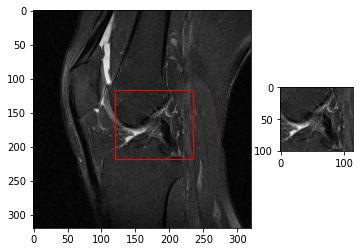

In [ ]:
# Plot slice and roi

figure = plt.figure()
plot = plt.subplot2grid((1, 4), (0, 0), 1, 3) # This makes the slice plot larger than roi plot
plot.add_patch(patch.Rectangle((x, y), w, h, fill=None, color='red'))
plot.imshow(slice, cmap='gray')
plot = plt.subplot2grid((1, 4), (0, 3), 1, 1)
plot.imshow(roi, cmap='gray')
        
plt.show()

In [ ]:
a=[]
df=pd.read_csv(metadata_csv_path)
#df = df.sample(n=15)     # k rows
print(df)

      examId  seriesNo  aclDiagnosis  ...  roiWidth  roiDepth  volumeFilename
0     329637         8             0  ...        72         3    329637-8.pck
1     390116         9             0  ...        98         6    390116-9.pck
2     404663         8             1  ...       115         2    404663-8.pck
3     406320         9             0  ...        80         3    406320-9.pck
4     412857         8             0  ...        98         4    412857-8.pck
..       ...       ...           ...  ...       ...       ...             ...
912  1027212         5             1  ...        99         3   1027212-5.pck
913  1028019         5             1  ...       100         3   1028019-5.pck
914  1028028         5             0  ...       100         2   1028028-5.pck
915  1028069         5             0  ...       106         4   1028069-5.pck
916  1028670         5             1  ...       110         4   1028670-5.pck

[917 rows x 11 columns]


In [ ]:
for MRI in df['volumeFilename']:
    for Dir in ("vol01","vol02","vol03","vol04","vol05","vol06","vol07","vol08","vol09","vol10"):
    
        my_file=Path("/content/drive/MyDrive/"+Dir+"/"+MRI )
    
        if my_file.exists():
            a.append(my_file)
    
print(a)

[PosixPath('/content/drive/MyDrive/vol01/329637-8.pck'), PosixPath('/content/drive/MyDrive/vol01/390116-9.pck'), PosixPath('/content/drive/MyDrive/vol01/404663-8.pck'), PosixPath('/content/drive/MyDrive/vol01/406320-9.pck'), PosixPath('/content/drive/MyDrive/vol01/412857-8.pck'), PosixPath('/content/drive/MyDrive/vol01/412865-8.pck'), PosixPath('/content/drive/MyDrive/vol01/415102-9.pck'), PosixPath('/content/drive/MyDrive/vol01/425707-8.pck'), PosixPath('/content/drive/MyDrive/vol01/425713-8.pck'), PosixPath('/content/drive/MyDrive/vol01/437474-8.pck'), PosixPath('/content/drive/MyDrive/vol01/444503-7.pck'), PosixPath('/content/drive/MyDrive/vol01/451760-9.pck'), PosixPath('/content/drive/MyDrive/vol01/454319-8.pck'), PosixPath('/content/drive/MyDrive/vol01/455741-8.pck'), PosixPath('/content/drive/MyDrive/vol01/456691-8.pck'), PosixPath('/content/drive/MyDrive/vol01/457181-8.pck'), PosixPath('/content/drive/MyDrive/vol01/457491-6.pck'), PosixPath('/content/drive/MyDrive/vol01/457511-

In [ ]:
df['path']="Image Not Here"
string1=[]
new_df=pd.DataFrame()
for i in a:
    string1.append(str(i))
print(string1)

['/content/drive/MyDrive/vol01/329637-8.pck', '/content/drive/MyDrive/vol01/390116-9.pck', '/content/drive/MyDrive/vol01/404663-8.pck', '/content/drive/MyDrive/vol01/406320-9.pck', '/content/drive/MyDrive/vol01/412857-8.pck', '/content/drive/MyDrive/vol01/412865-8.pck', '/content/drive/MyDrive/vol01/415102-9.pck', '/content/drive/MyDrive/vol01/425707-8.pck', '/content/drive/MyDrive/vol01/425713-8.pck', '/content/drive/MyDrive/vol01/437474-8.pck', '/content/drive/MyDrive/vol01/444503-7.pck', '/content/drive/MyDrive/vol01/451760-9.pck', '/content/drive/MyDrive/vol01/454319-8.pck', '/content/drive/MyDrive/vol01/455741-8.pck', '/content/drive/MyDrive/vol01/456691-8.pck', '/content/drive/MyDrive/vol01/457181-8.pck', '/content/drive/MyDrive/vol01/457491-6.pck', '/content/drive/MyDrive/vol01/457511-7.pck', '/content/drive/MyDrive/vol01/457519-6.pck', '/content/drive/MyDrive/vol01/457531-6.pck', '/content/drive/MyDrive/vol01/457572-6.pck', '/content/drive/MyDrive/vol01/459462-10.pck', '/conten

In [ ]:
print(df)

      examId  seriesNo  aclDiagnosis  ...  roiDepth  volumeFilename            path
0     329637         8             0  ...         3    329637-8.pck  Image Not Here
1     390116         9             0  ...         6    390116-9.pck  Image Not Here
2     404663         8             1  ...         2    404663-8.pck  Image Not Here
3     406320         9             0  ...         3    406320-9.pck  Image Not Here
4     412857         8             0  ...         4    412857-8.pck  Image Not Here
..       ...       ...           ...  ...       ...             ...             ...
912  1027212         5             1  ...         3   1027212-5.pck  Image Not Here
913  1028019         5             1  ...         3   1028019-5.pck  Image Not Here
914  1028028         5             0  ...         2   1028028-5.pck  Image Not Here
915  1028069         5             0  ...         4   1028069-5.pck  Image Not Here
916  1028670         5             1  ...         4   1028670-5.pck  Image N

In [ ]:
for b in string1:
    for i, row in df.iterrows():
        
        string2=b.split('/')
        if re.match(row['volumeFilename'],string2[5]):
            row['path']=b
            df1=row.to_frame()
            df1_transposed = df1.T
            frames = [df,df1_transposed]
            df=pd.concat(frames)
            break
print(df)   

      examId  ...                                        path
0     329637  ...                              Image Not Here
1     390116  ...   /content/drive/MyDrive/vol01/390116-9.pck
2     404663  ...   /content/drive/MyDrive/vol01/404663-8.pck
3     406320  ...   /content/drive/MyDrive/vol01/406320-9.pck
4     412857  ...   /content/drive/MyDrive/vol01/412857-8.pck
..       ...  ...                                         ...
912  1027212  ...  /content/drive/MyDrive/vol10/1027212-5.pck
913  1028019  ...  /content/drive/MyDrive/vol10/1028019-5.pck
914  1028028  ...  /content/drive/MyDrive/vol10/1028028-5.pck
915  1028069  ...  /content/drive/MyDrive/vol10/1028069-5.pck
916  1028670  ...  /content/drive/MyDrive/vol10/1028670-5.pck

[1826 rows x 12 columns]


In [ ]:
# Droping records for which we dont have Images
df=df[df['path']!="Image Not Here"]
print(df)

      examId  ...                                        path
1     390116  ...   /content/drive/MyDrive/vol01/390116-9.pck
2     404663  ...   /content/drive/MyDrive/vol01/404663-8.pck
3     406320  ...   /content/drive/MyDrive/vol01/406320-9.pck
4     412857  ...   /content/drive/MyDrive/vol01/412857-8.pck
5     412865  ...   /content/drive/MyDrive/vol01/412865-8.pck
..       ...  ...                                         ...
912  1027212  ...  /content/drive/MyDrive/vol10/1027212-5.pck
913  1028019  ...  /content/drive/MyDrive/vol10/1028019-5.pck
914  1028028  ...  /content/drive/MyDrive/vol10/1028028-5.pck
915  1028069  ...  /content/drive/MyDrive/vol10/1028069-5.pck
916  1028670  ...  /content/drive/MyDrive/vol10/1028670-5.pck

[1817 rows x 12 columns]


In [ ]:
# compter le nombre d'images pour chaque diagnostic
sizes=df.aclDiagnosis
x=pd.value_counts(sizes)
print(sizes)
print(x)

1      0
2      1
3      0
4      0
5      1
      ..
912    1
913    1
914    0
915    0
916    1
Name: aclDiagnosis, Length: 1817, dtype: object
0    1367
1     340
2     110
Name: aclDiagnosis, dtype: int64


([<matplotlib.patches.Wedge at 0x7f8c80599590>,
 [Text(-0.7835119685400957, 0.7720809511666664, '0'),
  Text(0.6234255129241096, -0.9062784504970375, '1'),
  Text(1.0801651529477847, -0.207950095833806, '2')])

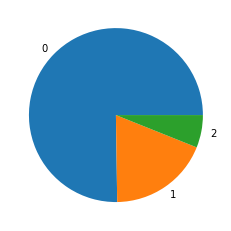

In [ ]:
# visualiser les proportions des diagnostic 

idx = pd.Int64Index([0,1,2])
Pie_Chart_df = pd.DataFrame(index = idx, data =(x))
plt.pie(Pie_Chart_df.aclDiagnosis,labels=Pie_Chart_df.index)

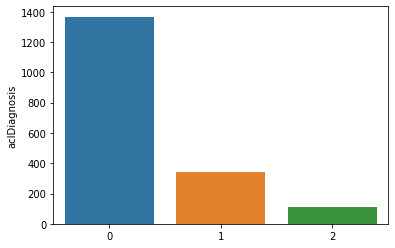

In [ ]:
# autre méthode
sns.barplot(x=Pie_Chart_df.index,y=Pie_Chart_df.aclDiagnosis)

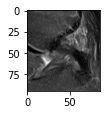

(95, 86)


In [ ]:
#taking record 6 to only visulaize the image

with open(df['path'].iloc[6], 'rb') as file_handler:       # Must use 'rb' as the data is binary
    volumetric_data = pickle.load(file_handler)


img=volumetric_data[df['roiZ'].iloc[6], :, :]

x=df["roiX"].iloc[6]
y=df["roiY"].iloc[6]
w=df["roiWidth"].iloc[6]
h=df["roiHeight"].iloc[6]

image_array=img[y:y+h, x:x+w]

figure = plt.figure()
plot = plt.subplot2grid((1, 4), (0, 3), 1, 1)       
plot.imshow(image_array, cmap='gray')
        
plt.show()
print(image_array.shape)

In [ ]:
# This is Our Deep Nueral Network Model On which we are going to Train our Images

from keras.models import Sequential
from keras.layers.core import Activation
from keras import regularizers
from keras.layers.convolutional import MaxPooling2D

In [ ]:

model=Sequential()
        
# conv2d set  =====> Conv2d====>relu=====>MaxPooling
model.add(Conv2D(20,(5,5),padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    
model.add(Conv2D(20,(5,5),padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    
model.add(Conv2D(20,(5,5),padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
   
model.add(Flatten())  
model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dropout(0.3))    
model.add(Dense(32))
model.add(Activation("relu"))
model.add(Dropout(0.3))   
        
model.add(Dense(3))
model.add(Activation("softmax"))
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.00001, decay=0),
              metrics=['accuracy'])

Now Lets see our model accuracy on Categorical Data

0: Healthy
1: half_Raptured
2: Full_Raptured


In [ ]:
images_path=df['path']
image_list = []

print(images_path)

1       /content/drive/MyDrive/vol01/390116-9.pck
2       /content/drive/MyDrive/vol01/404663-8.pck
3       /content/drive/MyDrive/vol01/406320-9.pck
4       /content/drive/MyDrive/vol01/412857-8.pck
5       /content/drive/MyDrive/vol01/412865-8.pck
                          ...                    
912    /content/drive/MyDrive/vol10/1027212-5.pck
913    /content/drive/MyDrive/vol10/1028019-5.pck
914    /content/drive/MyDrive/vol10/1028028-5.pck
915    /content/drive/MyDrive/vol10/1028069-5.pck
916    /content/drive/MyDrive/vol10/1028670-5.pck
Name: path, Length: 1817, dtype: object


In [ ]:
from tqdm import tqdm

for i in tqdm(range(len(df))):
    with open(df['path'].iloc[i], 'rb') as file_handler: # Must use 'rb' as the data is binary
        image_array = pickle.load(file_handler)
    img=image_array[df['roiZ'].iloc[i], :, :]
    x=df["roiX"].iloc[i]
    y=df["roiY"].iloc[i]
    w=df["roiWidth"].iloc[i]
    h=df["roiHeight"].iloc[i]
    image_array=img[y:y+h, x:x+w]
    
    imageB_array = resize(image_array, (90, 90))
    image_list.append(imageB_array)
    
img_list=np.asarray(image_list)

Y=df.aclDiagnosis
Y=np.asarray(Y)
Y = to_categorical(Y, num_classes=3)
print(Y)

100%|██████████| 1817/1817 [29:49<00:00,  1.02it/s]

[[1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]


In [ ]:
img_list = img_list.reshape(-1, 90,90,1)
print(img_list.shape)

(1817, 90, 90, 1)


In [ ]:
# split the data into training set and test set

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    img_list,Y, test_size=0.10, random_state=42)

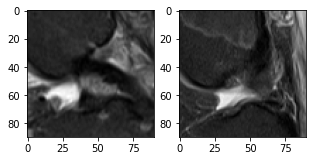

In [ ]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(X_train[0], (90,90))
plt.imshow(curr_img, cmap='gray')

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(X_test[0], (90,90))
plt.imshow(curr_img, cmap='gray')

Epoch 1/10
52/52 [==============================] - 51s 9ms/step - loss: 0.6924 - accuracy: 0.6169
Epoch 2/10
52/52 [==============================] - 0s 7ms/step - loss: 0.6883 - accuracy: 0.7552
Epoch 3/10
52/52 [==============================] - 0s 7ms/step - loss: 0.6763 - accuracy: 0.7633
Epoch 4/10
52/52 [==============================] - 0s 7ms/step - loss: 0.6468 - accuracy: 0.7546
Epoch 5/10
52/52 [==============================] - 0s 7ms/step - loss: 0.5991 - accuracy: 0.7369
Epoch 6/10
52/52 [==============================] - 0s 7ms/step - loss: 0.5262 - accuracy: 0.7538
Epoch 7/10
52/52 [==============================] - 0s 7ms/step - loss: 0.4840 - accuracy: 0.7560
Epoch 8/10
52/52 [==============================] - 0s 7ms/step - loss: 0.4638 - accuracy: 0.7577
Epoch 9/10
52/52 [==============================] - 0s 7ms/step - loss: 0.4932 - accuracy: 0.7247
Epoch 10/10
52/52 [==============================] - 0s 7ms/step - loss: 0.4627 - accuracy: 0.7554


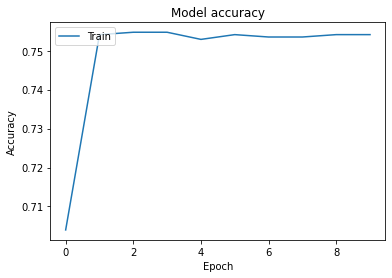

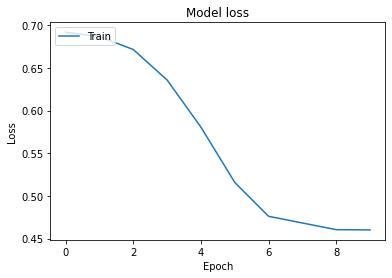

In [ ]:
history = model.fit(X_train, y_train, epochs=10)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
scores = model.evaluate(X_test,y_test)

print('Loss: %.3f' % scores[0])
print('Accuracy: %.3f' % scores[1])

6/6 [==============================] - 1s 20ms/step - loss: 0.4544 - accuracy: 0.7308
Loss: 0.454
Accuracy: 0.731


In [ ]:
x=model.predict(X_test)

#images which are labeled as Half Raptured
for i in range(1,74):
    ind = np.argmax(x[i])
    
    if ind == 1 : print("Half Raptured Image" + str(i))
    if ind == 2 : print("Full Ruptured Image")

In [ ]:
i=int(input("Enter Number Of image you want to check: "))

Predicted_label = np.argmax(x[i])
print("Predicted label is = ")
if Predicted_label == 0 : print("Healthy Image")
if Predicted_label == 1 : print("Half Raptured Image")
if Predicted_label == 2 : print("Full Ruptured Image")
    
    
True_Label = np.argmax(y_test[i])
print("True label is = ")
if True_Label == 0 : print("Healthy Image")
if True_Label == 1 : print("Half Raptured Image")
if True_Label == 2 : print("Full Ruptured Image")



Enter Number Of image you want to check: 46
Predicted label is = 
Healthy Image
True label is = 
Healthy Image
